In [1]:
!pip install pandas numpy seaborn matplotlib tqdm statsmodels

<h2 style="color:darkred">IMPORTING LIBRARIES</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error ,mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
from IPython.display import Image 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the CSV file into a DataFrame
file_path = 'weather_revised.csv'
df_weather = pd.read_csv(file_path, encoding='ascii')

# Display the head of the DataFrame
df_weather.head()

,date,maxtp(Maximum Air Temperature - degrees C),mintp(Minimum Air Temperature - degrees C),gmin(Grass Minimum Temperature - degrees C),rain(Precipitation Amount - mm),cbl (Mean CBL Pressure-hpa),wdsp(Mean Wind Speed - knot),pe(Potential Evapotranspiration - mm),evap(Evaporation -mm)
0,1-Jan-42,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4
1,2-Jan-42,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9
2,3-Jan-42,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6
3,4-Jan-42,9.2,2.7,3.4,3.5,1001.5,17.0,0.6,0.7
4,5-Jan-42,3.5,-0.8,0,0.6,1013.4,13.0,0.6,0.7


<h2 style="color:darkred">DATA PRE-PROCESSING </h2>

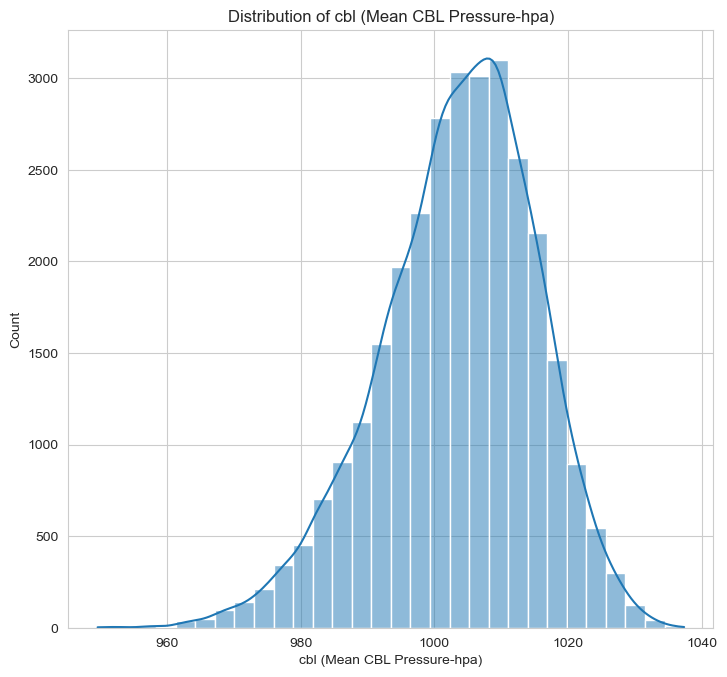

In [3]:
def plot_distributions(dataframe, columns):
    # Set the aesthetic style of the plots
    sns.set_style('whitegrid')
    
    # Define the number of rows and columns for subplots
    num_rows = (len(columns) + 1)
    num_cols = 2
    
    plt.figure(figsize=(14, 7 + 3 * num_rows))
    
    # Plot each distribution
    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(dataframe[column], bins=30, kde=True)
        plt.title(f'Distribution of {column}')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
selected_columns = ['cbl (Mean CBL Pressure-hpa)']

plot_distributions(df_weather, selected_columns)

In [4]:
# Summary statistics for maxtp
print(df_weather['cbl (Mean CBL Pressure-hpa)'].describe())

count    29889.000000
mean      1003.520208
std         11.723154
min        949.600000
25%        996.200000
50%       1004.600000
75%       1011.700000
max       1037.400000
Name: cbl (Mean CBL Pressure-hpa), dtype: float64


In [5]:
#Check datatypes of data
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29889 entries, 0 to 29888
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   date                                         29889 non-null  object 
 1   maxtp(Maximum Air Temperature - degrees C)   29889 non-null  float64
 2   mintp(Minimum Air Temperature - degrees C)   29889 non-null  float64
 3   gmin(Grass Minimum Temperature - degrees C)  29889 non-null  object 
 4   rain(Precipitation Amount - mm)              29889 non-null  float64
 5   cbl (Mean CBL Pressure-hpa)                  29889 non-null  float64
 6   wdsp(Mean Wind Speed - knot)                 29889 non-null  float64
 7   pe(Potential Evapotranspiration - mm)        29889 non-null  float64
 8   evap(Evaporation -mm)                        29889 non-null  object 
dtypes: float64(6), object(3)
memory usage: 2.1+ MB
None


<h2 style="color:darkred">Checking Missing, Unique, Duplicate, NaN values count</h2>

In [6]:
# check for missing values, unique and duplicate values
missing_values = df_weather.isnull().sum()
unique_values = df_weather.nunique()
duplicated_rows = df_weather.duplicated().sum()
Nan_values = df_weather.isna().sum()

result = pd.DataFrame({
    "Unique values": unique_values,
    "Missing values": missing_values,
    "Duplicated values": duplicated_rows,
    
    "NaN values": Nan_values
})
result

,Unique values,Missing values,Duplicated values,NaN values
date,29889,0,0,0
maxtp(Maximum Air Temperature - degrees C),294,0,0,0
mintp(Minimum Air Temperature - degrees C),269,0,0,0
gmin(Grass Minimum Temperature - degrees C),300,0,0,0
rain(Precipitation Amount - mm),361,0,0,0
cbl (Mean CBL Pressure-hpa),731,0,0,0
wdsp(Mean Wind Speed - knot),291,0,0,0
pe(Potential Evapotranspiration - mm),55,0,0,0
evap(Evaporation -mm),76,0,0,0


In [7]:
# Convert date column to datetime
# The dates are in the format 'd-Mon-yy', and we need to account for the century
def parse_date(x):
    day, month, year = x.split('-')
    year = '19' + year if int(year) <= 99 and int(year) >= 42 else '20' + year
    return '-'.join([day, month, year])

In [8]:
df_weather_processed = df_weather.copy()

# Apply parse_date function
df_weather_processed['date'] = df_weather['date'].apply(parse_date)

In [9]:
df_weather_processed.head(3)

,date,maxtp(Maximum Air Temperature - degrees C),mintp(Minimum Air Temperature - degrees C),gmin(Grass Minimum Temperature - degrees C),rain(Precipitation Amount - mm),cbl (Mean CBL Pressure-hpa),wdsp(Mean Wind Speed - knot),pe(Potential Evapotranspiration - mm),evap(Evaporation -mm)
0,1-Jan-1942,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4
1,2-Jan-1942,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9
2,3-Jan-1942,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6


In [10]:
# Convert to datetime
df_weather_processed['date'] = pd.to_datetime(df_weather_processed['date'], format='%d-%b-%Y', errors='coerce')

In [11]:
df_weather['date'].head()

0    1-Jan-42
1    2-Jan-42
2    3-Jan-42
3    4-Jan-42
4    5-Jan-42
Name: date, dtype: object

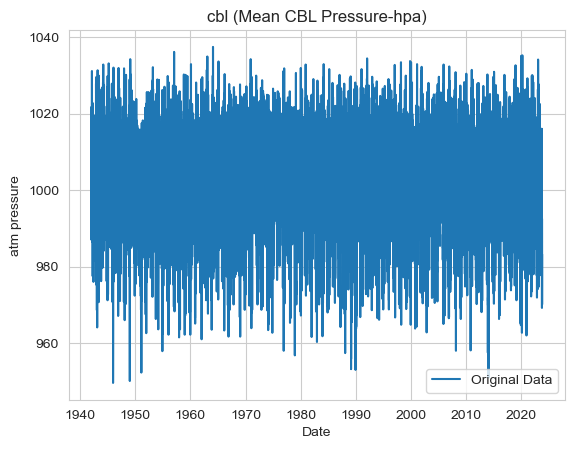

In [12]:
plt.plot(df_weather_processed['date'], df_weather_processed['cbl (Mean CBL Pressure-hpa)'], label='Original Data')
plt.title('cbl (Mean CBL Pressure-hpa)')
plt.xlabel('Date')
plt.ylabel('atm pressure')
plt.legend()
plt.show()

In [13]:
print(df_weather_processed.columns)


Index(['date', 'maxtp(Maximum Air Temperature - degrees C)',
       'mintp(Minimum Air Temperature - degrees C)',
       'gmin(Grass Minimum Temperature - degrees C)',
       'rain(Precipitation Amount - mm)', 'cbl (Mean CBL Pressure-hpa)',
       'wdsp(Mean Wind Speed - knot)', 'pe(Potential Evapotranspiration - mm)',
       'evap(Evaporation -mm)'],
      dtype='object')


In [14]:
df_weather_processed.head()

,date,maxtp(Maximum Air Temperature - degrees C),mintp(Minimum Air Temperature - degrees C),gmin(Grass Minimum Temperature - degrees C),rain(Precipitation Amount - mm),cbl (Mean CBL Pressure-hpa),wdsp(Mean Wind Speed - knot),pe(Potential Evapotranspiration - mm),evap(Evaporation -mm)
0,1942-01-01,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4
1,1942-01-02,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9
2,1942-01-03,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6
3,1942-01-04,9.2,2.7,3.4,3.5,1001.5,17.0,0.6,0.7
4,1942-01-05,3.5,-0.8,0,0.6,1013.4,13.0,0.6,0.7


In [15]:
df_weather_processed.set_index('date', inplace=True)

<h2 style="color:darkred">Detecting Outliers</h2>

In [18]:
Conti_Features = ['cbl (Mean CBL Pressure-hpa)','wdsp(Mean Wind Speed - knot)']

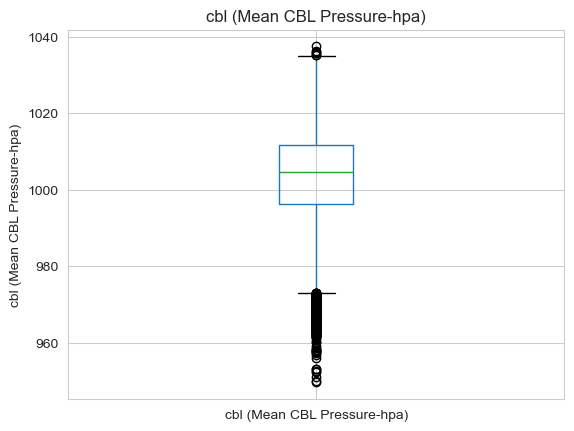

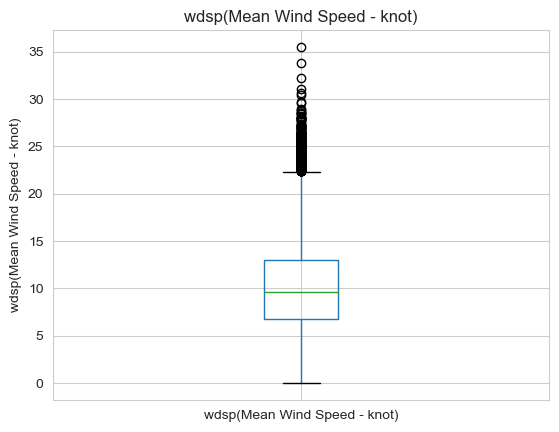

In [19]:
for feature in Conti_Features:
        df_weather_processed.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()
        

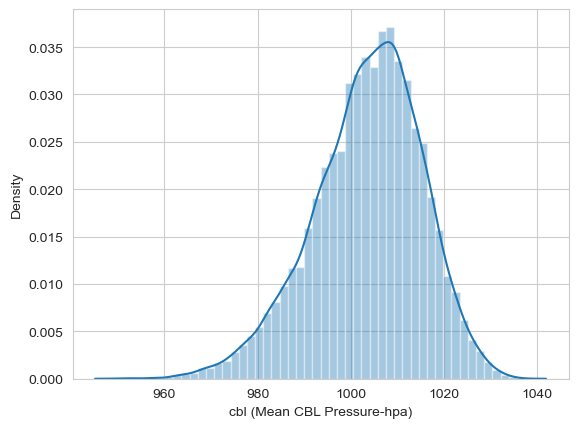

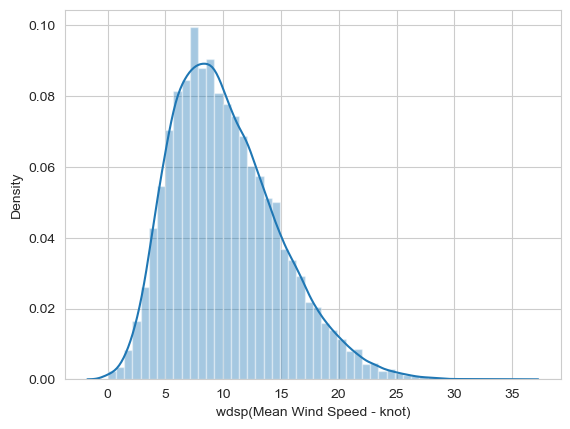

In [20]:
for var in Conti_Features:
    sns.distplot(df_weather_processed[var])
    plt.show()

In [21]:
for feature in Conti_Features:
    Q1 = df_weather_processed[feature].quantile(0.25)
    Q3 = df_weather_processed[feature].quantile(0.75)
    IQR = Q3 - Q1
    print('IQR of {} is '.format(feature),IQR )

IQR of cbl (Mean CBL Pressure-hpa) is  15.5
IQR of wdsp(Mean Wind Speed - knot) is  6.2


In [22]:
for feature in Conti_Features:
    print(feature ," - ", df_weather_processed[feature].skew())
    

cbl (Mean CBL Pressure-hpa)  -  -0.4637217911105772
wdsp(Mean Wind Speed - knot)  -  0.6649087650408657


In [23]:
atm_pressure = df_weather_processed.copy()

In [24]:
# Quantile-based Flooring and Capping 
for feature in Conti_Features:
        Q1 = atm_pressure[feature].quantile(0.25)
        Q3 = atm_pressure[feature].quantile(0.75)

        IQR = Q3-Q1

        outliers_atm_data = ((atm_pressure[feature] < (Q1-1.5*IQR)) | (atm_pressure[feature] > (Q3+1.5*IQR))) #picked outliers
        median_N_col = atm_pressure[feature].median()
        #print(median_N_col)
        print(f'number of outliers: {atm_pressure[outliers_atm_data].shape[0]}')
        atm_pressure.loc[outliers_atm_data, feature] = median_N_col

for feature in Conti_Features:
    print(feature ," - ", atm_pressure[feature].skew())

number of outliers: 336
number of outliers: 375
cbl (Mean CBL Pressure-hpa)  -  -0.2803704343767963
wdsp(Mean Wind Speed - knot)  -  0.46446982309737256


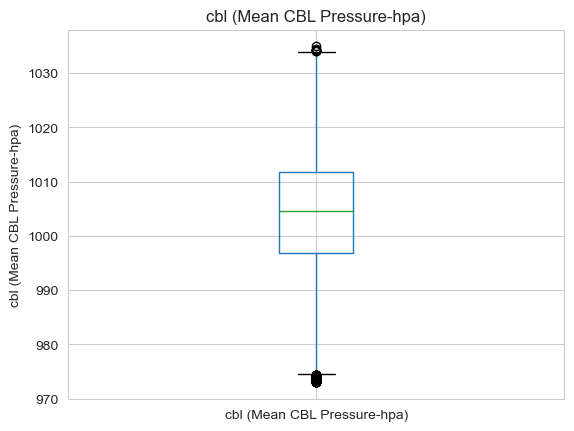

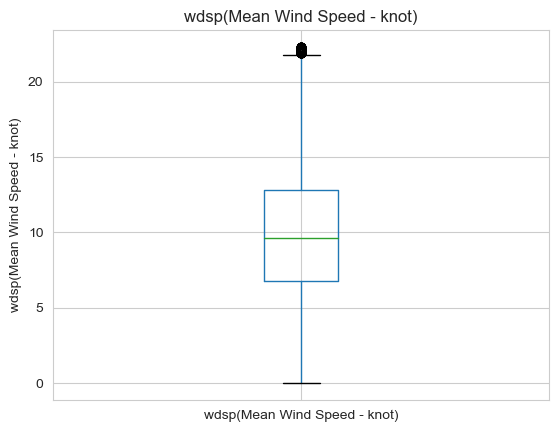

In [25]:
for feature in Conti_Features:
        atm_pressure.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

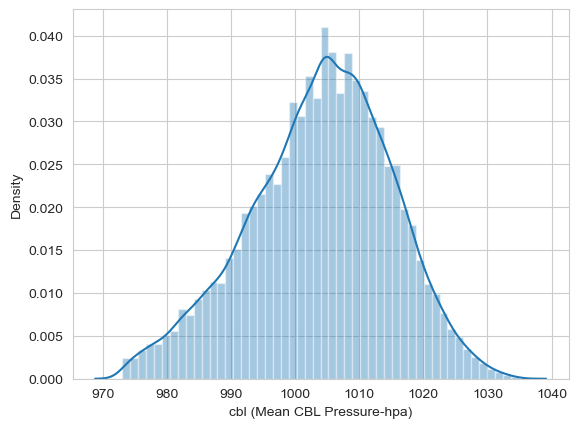

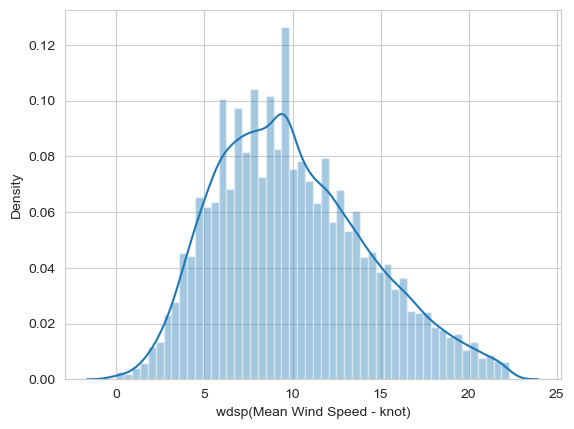

In [26]:
for var in Conti_Features:
    sns.distplot(atm_pressure[var])
    plt.show()

In [27]:
# Specify the time range for training (2019 to 2022) and testing (from 2023 onwards)
train_start_date = '2019-01-01'
train_end_date = '2022-12-31'
test_start_date = '2023-01-01'

# Split the data into training and testing sets with daily frequency
train_df = atm_pressure[train_start_date:train_end_date]['wdsp(Mean Wind Speed - knot)'].resample('M').fillna(method='pad')
test_df = atm_pressure[test_start_date:]['wdsp(Mean Wind Speed - knot)'].resample('M').fillna(method='pad')


In [28]:
train_df.head()

date
2019-01-31    11.7
2019-02-28     6.3
2019-03-31     8.3
2019-04-30     7.3
2019-05-31    10.5
Freq: M, Name: wdsp(Mean Wind Speed - knot), dtype: float64

In [29]:
test_df.head()

date
2023-01-31    15.8
2023-02-28     8.9
2023-03-31     8.5
2023-04-30     7.5
2023-05-31     8.9
Freq: M, Name: wdsp(Mean Wind Speed - knot), dtype: float64

In [30]:
test_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 10 entries, 2023-01-31 to 2023-10-31
Freq: M
Series name: wdsp(Mean Wind Speed - knot)
Non-Null Count  Dtype  
--------------  -----  
10 non-null     float64
dtypes: float64(1)
memory usage: 160.0 bytes


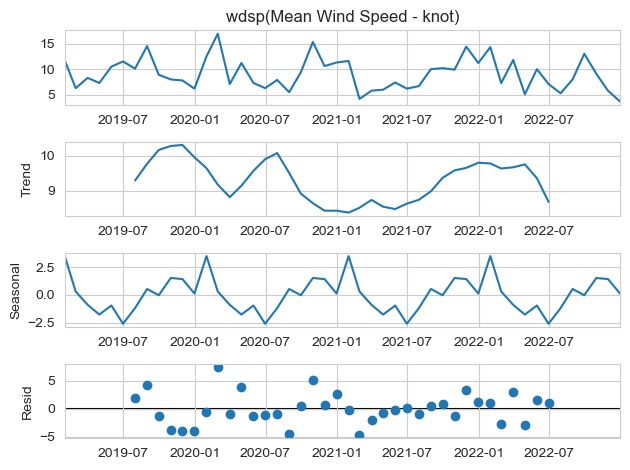

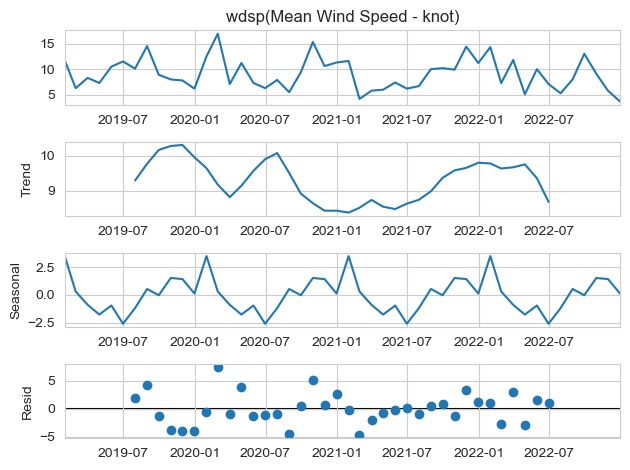

In [31]:
result = seasonal_decompose(train_df)
result.plot()

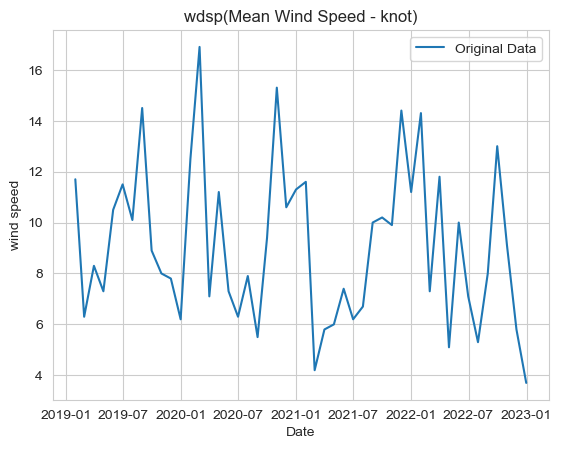

In [32]:
plt.plot( train_df, label='Original Data')
plt.title('wdsp(Mean Wind Speed - knot)')
plt.xlabel('Date')
plt.ylabel('wind speed')
plt.legend()
plt.show()

<h2 style="color:darkred">Checking whether Data is Stationary or Non-Stationary </h2>

In [33]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming your time series data is in the 'cbl (Mean CBL Pressure-hpa)' column
time_series_data = df_weather_processed['wdsp(Mean Wind Speed - knot)']

# Perform Augmented Dickey-Fuller test
result = adfuller(time_series_data)
df_stationarityTest = adfuller(df_weather_processed['wdsp(Mean Wind Speed - knot)'], autolag='AIC')

adf_statistic = df_stationarityTest[0]
print('ADF Statistic:', adf_statistic)
# Extract and print the p-value
p_value = result[1]
print("ADF Test p-value:", p_value)

# Check if the time series is stationary based on the p-value
if p_value <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")


ADF Statistic: -16.847133283439526
ADF Test p-value: 1.1261694867802569e-29
The time series is likely stationary.


In [34]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(30).mean()
    rolling_std = ts.rolling(30).std()
    plt.figure(figsize=(6,4))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

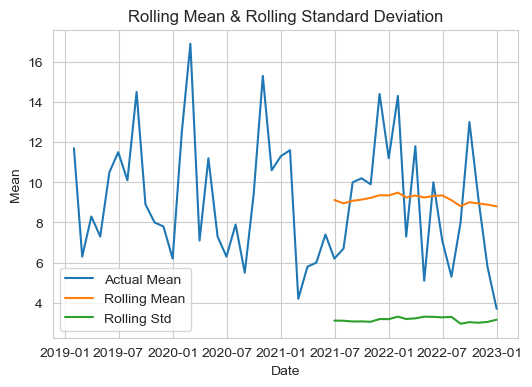

In [35]:
# check stationary: mean, variance(std)
plot_rolling_mean_std(train_df)

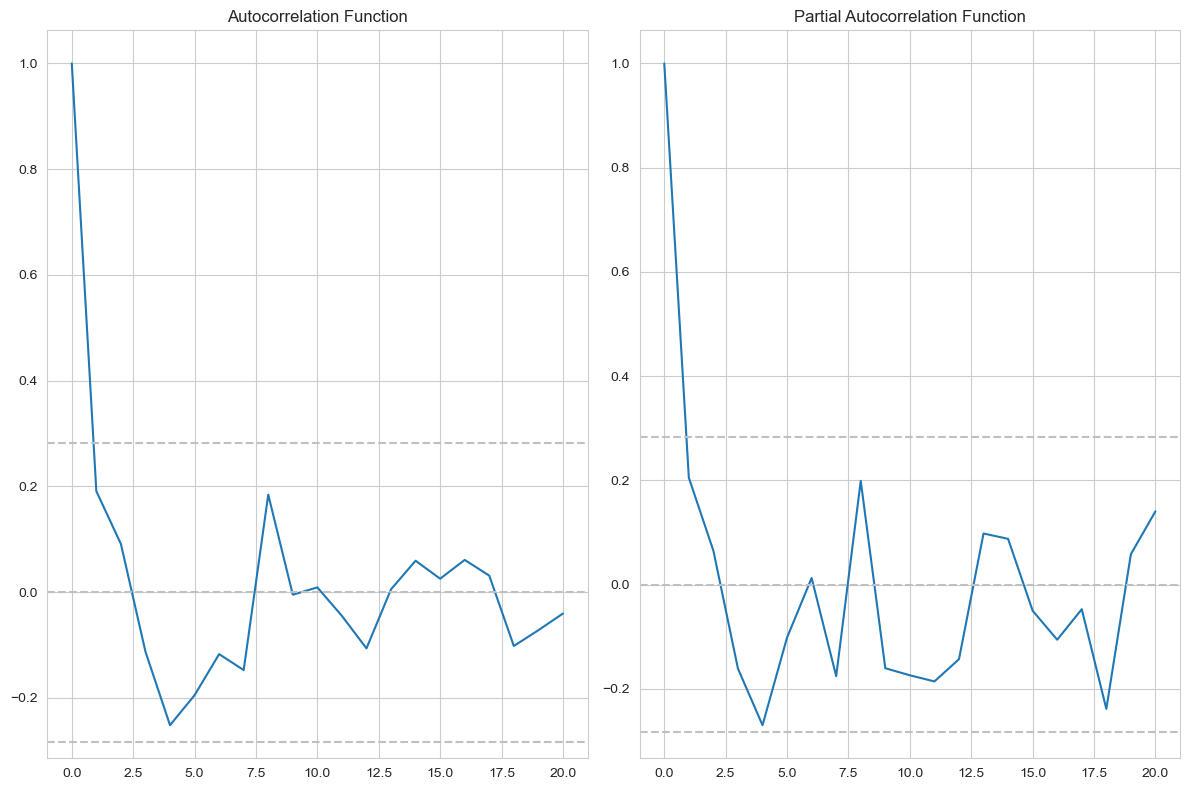

In [36]:
#Plot ACF and PACF
acf_lag = acf(train_df.values, nlags=20)
pacf_lag = pacf(train_df.values, nlags=20, method='ols')

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(1,2,2)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

<h2 style="color:darkred">Ploting ACF and PACF </h2>

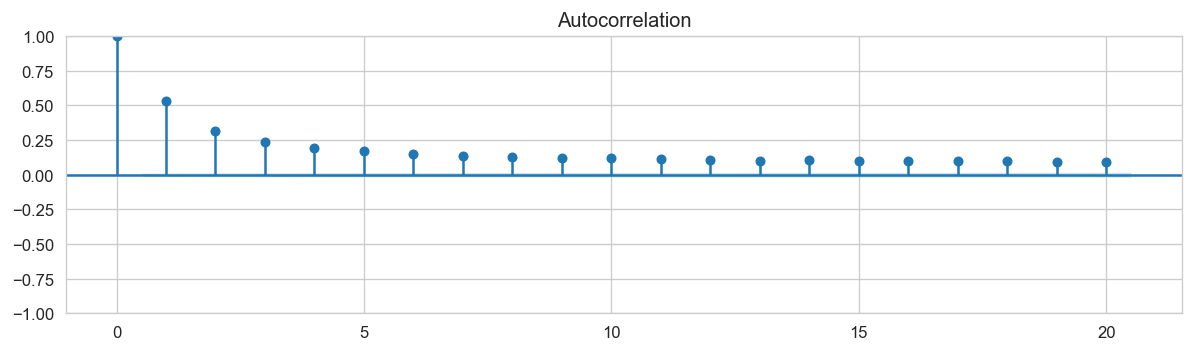

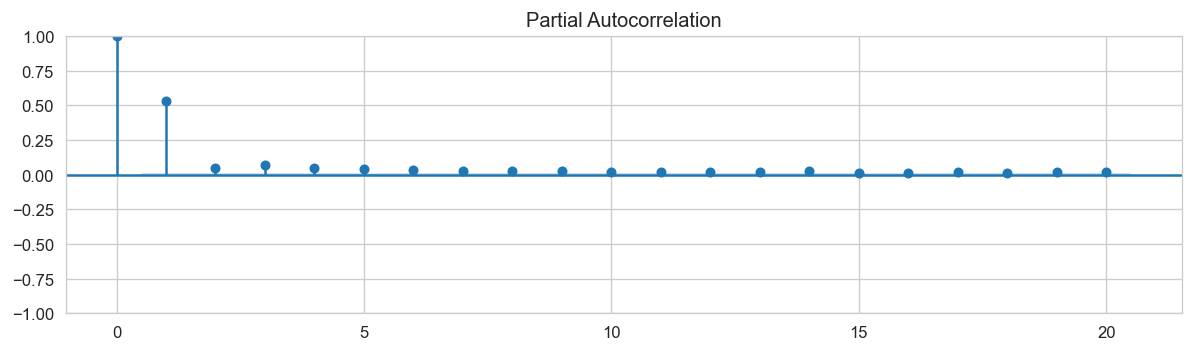

In [73]:
# Plot ACF and PACF to determine orders
plot_acf(atm_pressure['wdsp(Mean Wind Speed - knot)'], lags=20)
plt.show()

plot_pacf(atm_pressure['wdsp(Mean Wind Speed - knot)'], lags=20)
plt.show()

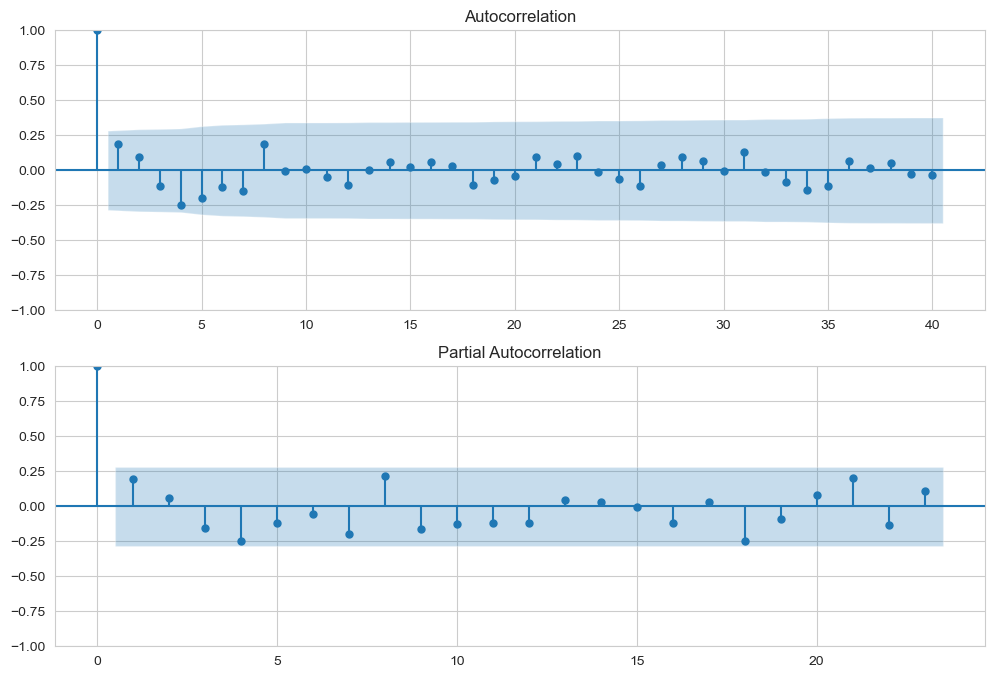

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df,lags=23,ax=ax2)

<h2 style="color:darkred">Forecasting Using AR MODEL </h2>

In [69]:
lags = 18
model = AutoReg(train_df, lags=lags)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                                 AutoReg Model Results                                  
Dep. Variable:     wdsp(Mean Wind Speed - knot)   No. Observations:                   48
Model:                              AutoReg(18)   Log Likelihood                 -69.639
Method:                         Conditional MLE   S.D. of innovations              2.465
Date:                          Wed, 10 Jan 2024   AIC                            179.279
Time:                                  12:11:25   BIC                            207.303
Sample:                              07-31-2020   HQIC                           188.244
                                   - 12-31-2022                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               25.1136     11.533      2.178      0.029       2.5

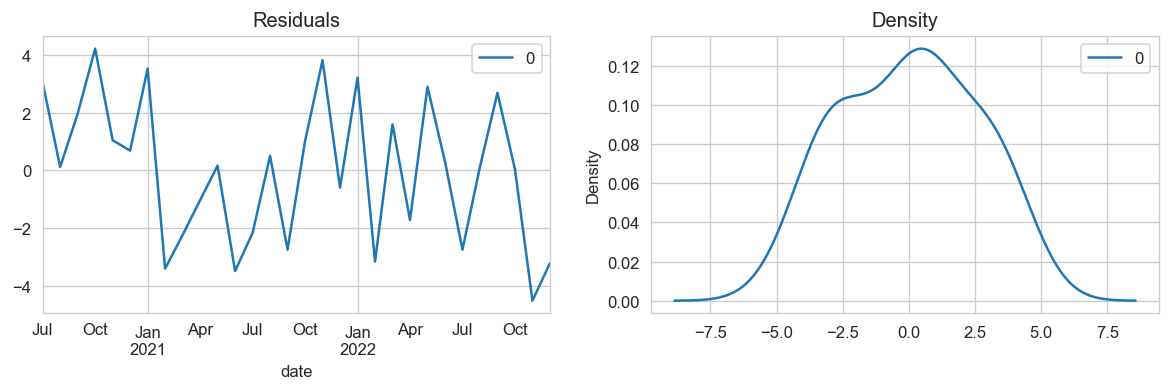

In [70]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Mean Absolute Error (MAE): 1.616241545274871
Test Mean Squared Error:  4.033366034788865
Root Mean Squared Error (RMSE): 2.0083241856804057


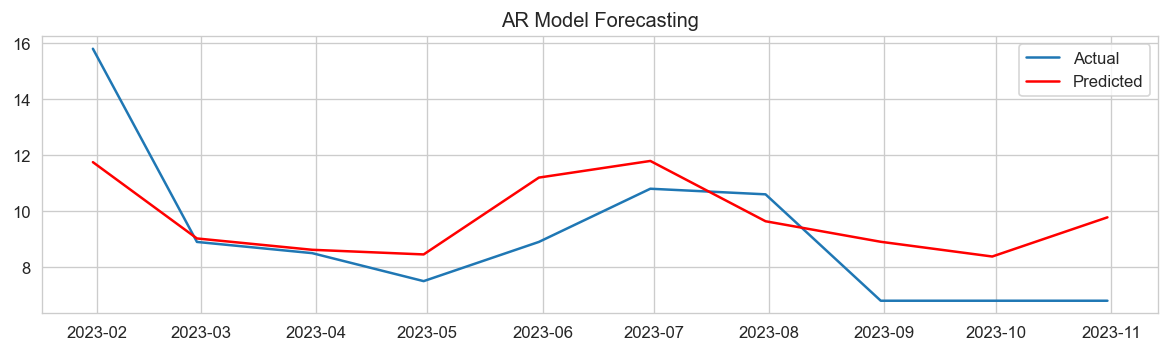

In [71]:
# Make predictions on the test set
predictions = model_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, dynamic=False)
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_df, predictions)


print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(test_df, predictions)
print('Test Mean Squared Error: ',mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the original vs. predicted values
plt.plot(test_df.index, test_df.values, label='Actual')
plt.plot(test_df.index, predictions, color='red', label='Predicted')
plt.title('AR Model Forecasting')
plt.legend()
plt.show()

<h2 style="color:darkred">Forecasting Using ARIMA MODEL </h2>

In [130]:
 model = ARIMA(train_df.values, order=(2, 0,17))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                ARIMA(2, 0, 17)   Log Likelihood                -112.162
Date:                Wed, 10 Jan 2024   AIC                            266.325
Time:                        12:17:35   BIC                            305.620
Sample:                             0   HQIC                           281.174
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1703      0.345     26.596      0.000       8.494       9.846
ar.L1          0.4244      1.563      0.272      0.786      -2.639       3.488
ar.L2         -0.4794      0.973     -0.493      0.6

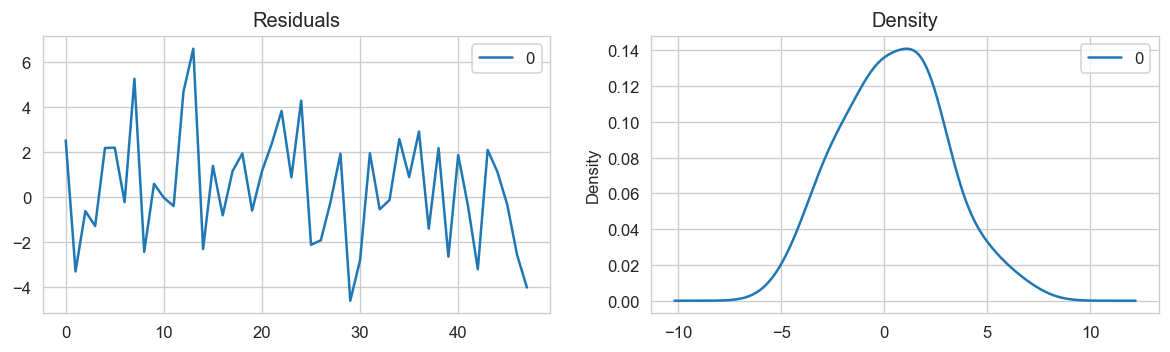

In [131]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

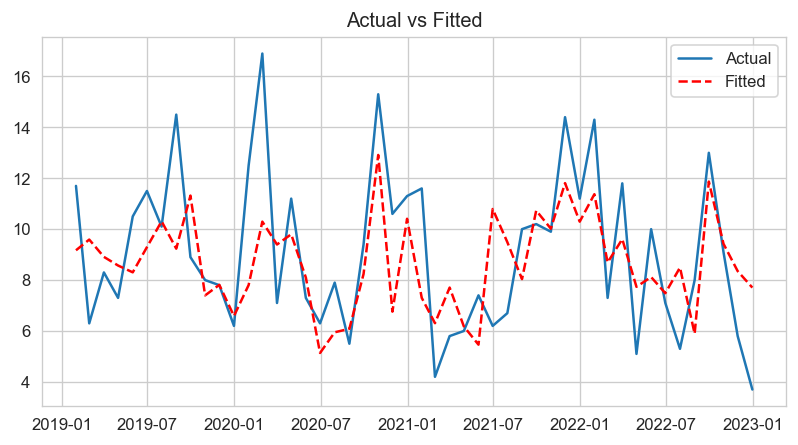

In [132]:
# Actual vs Fitted
plt.figure(figsize=(8, 4))
plt.plot(train_df.index, train_df.values, label='Actual')
plt.plot(train_df.index, model_fit.fittedvalues, color='red', label='Fitted', linestyle='--')
plt.legend()
plt.title('Actual vs Fitted')
plt.show()

In [133]:
# Forecast values for test_df
forecast_result = model_fit.get_forecast(10, alpha=0.05)

forecast_result

In [134]:
# Extracting forecast, standard errors, and confidence intervals
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int()

In [135]:
# Make as pandas series

fc_series_AR = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

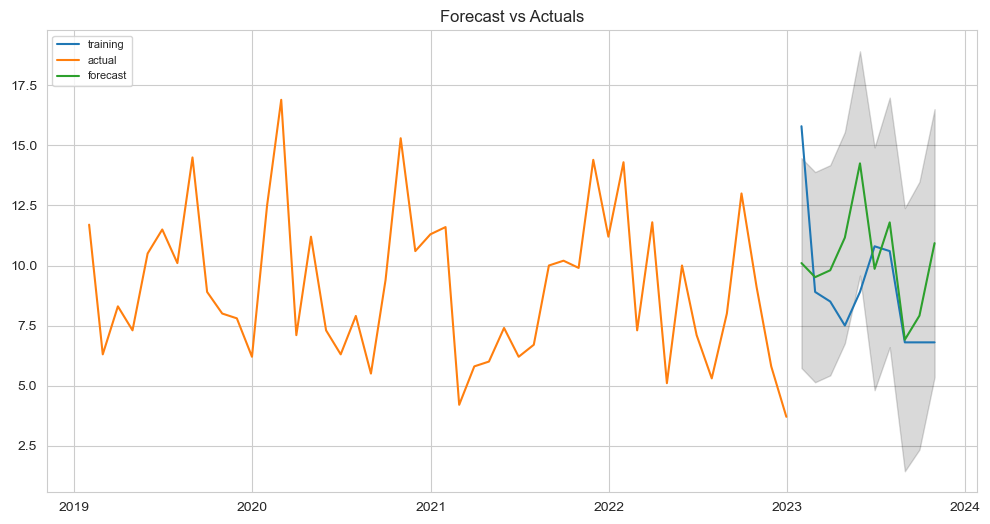

In [136]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(test_df, label='training')
plt.plot(train_df, label='actual')
plt.plot(fc_series_AR, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

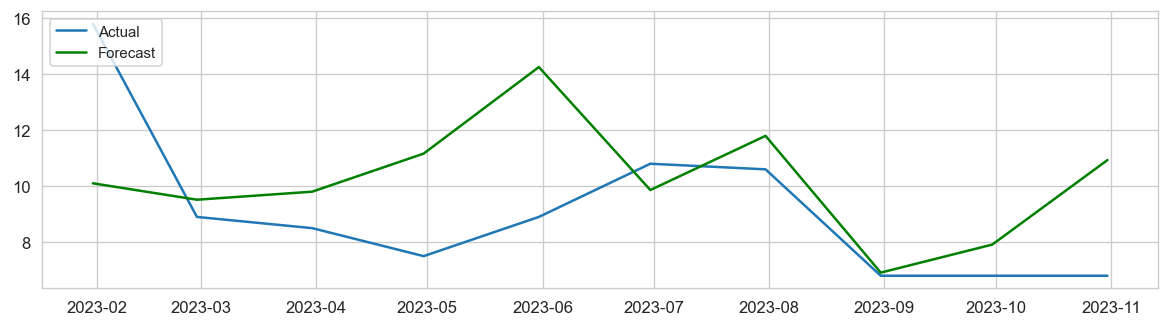

In [137]:
# plot Testing and Forecasted data
plt.plot(test_df, label='Actual')
plt.plot(fc_series_AR, label='Forecast', color='green')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [138]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_df, fc_series_AR)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(test_df, fc_series_AR)
print('Test Mean Squared Error: ',mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 2.4117999337276856
Test Mean Squared Error:  9.722809014655752
Root Mean Squared Error (RMSE): 3.118141917016567


<h2 style="color:darkred">Forecasting Using SARIMA </h2>

In [ ]:
# Specify the order and seasonal_order based on ACF and PACF analysis
order = (2, 0, 17)
seasonal_order = (2, 0, 17, 20)

# Create and fit the SARIMA model
sarima_model = SARIMAX(train_df, order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Display the model summary
print(sarima_model_fit.summary())

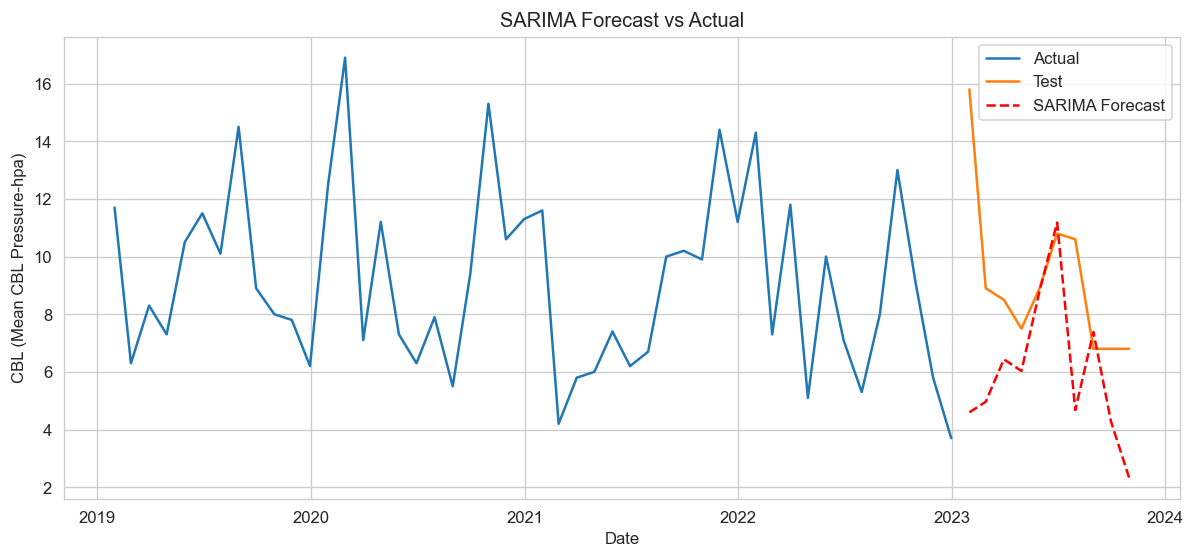

In [142]:
# Get the forecast
forecast_steps = 10
sarima_forecast = sarima_model_fit.get_forecast(steps=forecast_steps)

# Plot the actual values and the forecasted values
plt.figure(figsize=(12, 5))
plt.plot(train_df, label='Actual')
plt.plot(test_df,label='Test')
plt.plot(sarima_forecast.predicted_mean, color='red', label='SARIMA Forecast',linestyle='--')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend()
plt.show()


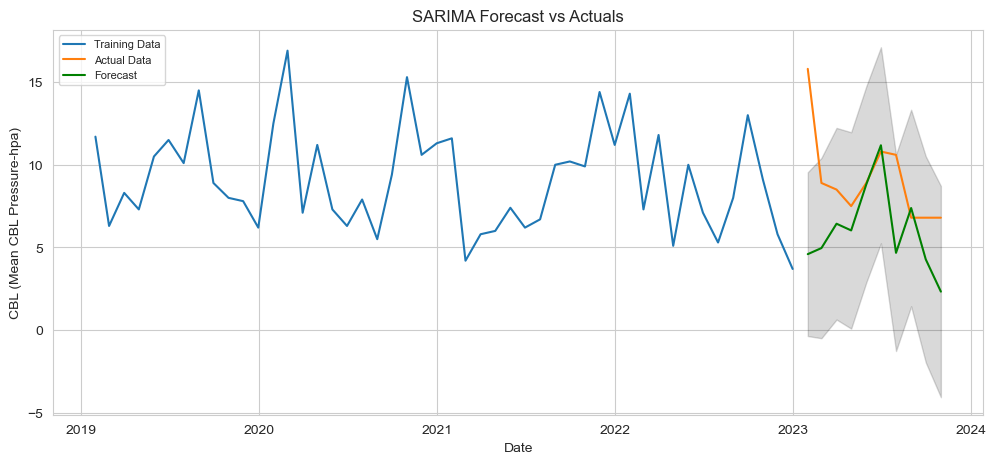

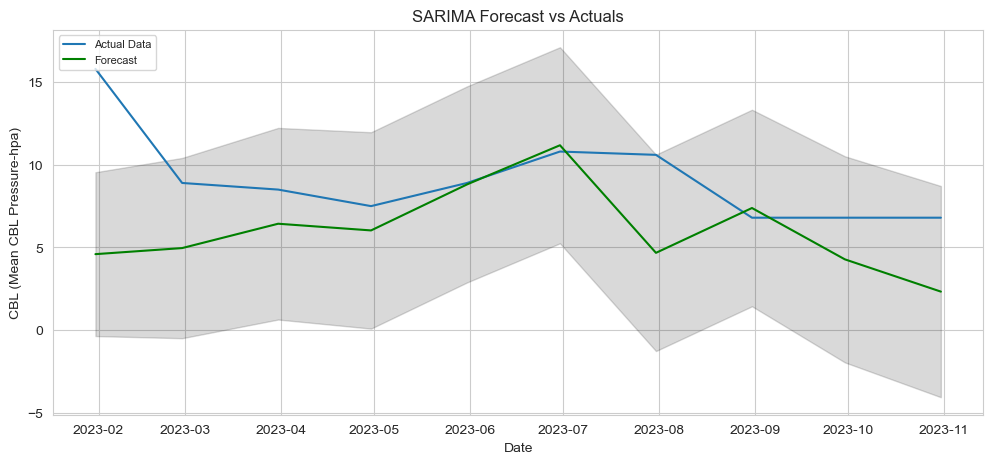

In [143]:
# Get the forecast
forecast_result = sarima_model_fit.get_forecast(steps=10, alpha=0.05)

# Extract forecasted values and confidence intervals
fc = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Make pandas series
fc_series_SR = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=test_df.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test_df.index)

# Plotting forecast vs actuals with prediction intervals
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_df, label='Training Data')
plt.plot(test_df, label='Actual Data')
plt.plot(fc_series_SR, label='Forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('SARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Plotting only the forecasted values with prediction intervals
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(test_df, label='Actual Data')

plt.plot(fc_series_SR, label='Forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('SARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [53]:

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_df, fc_series_SR)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(test_df, fc_series_SR)
print('Test Mean Squared Error: ',mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

<h2 style="color:darkred">Forecasting Using Exponential Smoothing </h2>

In [54]:
ets_model = ExponentialSmoothing(train_df, trend='add', seasonal='add', seasonal_periods=10)
ets_model_fit = ets_model.fit()

# Specify the number of steps to forecast (length of test_df)
forecast_steps = 10

# Get the forecast
ets_forecast = ets_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
print(ets_model_fit.summary())

# Plot the actual values and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df, label='Training Data')
plt.plot(test_df.index, test_df, label='Test Data')
plt.plot(test_df.index, ets_forecast, color='red', label='ETS Forecast')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Your Variable Name')
plt.legend()
plt.show()

In [55]:
# Specify the number of steps to forecast
forecast_steps = 10

# Get the forecast
ets_forecast = ets_model_fit.forecast(steps=forecast_steps)

# Calculate prediction intervals manually
confidence_interval = 0.95
forecast_std = np.std(ets_model_fit.resid)
z_score = stats.norm.ppf(1 - (1 - confidence_interval) / 2)
lower_series = ets_forecast - z_score * forecast_std
upper_series = ets_forecast + z_score * forecast_std

# Make pandas series
fc_series_ES = pd.Series(ets_forecast, index=test_df.index)
lower_series = pd.Series(lower_series, index=test_df.index)
upper_series = pd.Series(upper_series, index=test_df.index)

# Plotting forecast vs actuals with prediction intervals
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_df.index, train_df, label='Training Data')
plt.plot(test_df.index, test_df, label='Actual Data')
plt.plot(test_df.index, fc_series_ES, label='Forecast', color='green')
plt.fill_between(test_df.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Plotting only the forecasted values with prediction intervals
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(test_df.index, test_df, label='Actual Data')
plt.plot(test_df.index, fc_series_ES, label='Forecast', color='green')
plt.fill_between(test_df.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('CBL (Mean CBL Pressure-hpa)')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [56]:

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_df, fc_series_ES)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(test_df, fc_series_ES)
print('Test Mean Squared Error: ',mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

<h2 style="color:darkred">Conclusion</h2>

In [57]:
# get the image 
Image(url="Model-evaluation.png", width=700, height=600) 

The above model evaluation shows us the comparison between various time-series models. There are various aspects on which best model can be selected such as on the basis of AIC and BIC we can conclude that auto-regression (AR) and Exponential Smoothing is the best fitted model and on the basis of mean absolute error (MAE), mean squared error and root mean squared error ARIMA and Exponential smoothing are the best fitted model for forecasting Atmospheric pressure of the given data